# K Nearest Neighbor
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using K-nearest Neighbor to classify the data points on the target ("Outcome" of the stop and search).

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

In [3]:
def evaluate(model, X_train, y_train, X_test, y_test, average='weighted'):
    print(f"Accurancy Score (Train): {int(np.around(model.score(X_train, y_train), 2) * 100)}%")
    print(f"Accuracy Score (Test): {int(np.around(model.score(X_test, y_test), 2) * 100)}%")
    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    print(f"\nPrecision Score (Train): {int(np.around(precision_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Precision Score (Test): {int(np.around(precision_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nRecall Score (Train): {int(np.around(recall_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Recall Score (Test): {int(np.around(recall_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nF1 Score (Train): {int(np.around(f1_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"F1 Score (Test): {int(np.around(f1_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print("\n Confusion Matrix")
    util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions)

## Cleaning the Data set

In [4]:
data = pd.read_csv("data.csv")

# data = data.dropna()
data = util.data_cleaner(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values


In [5]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split data into train and test

In [6]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=25)

In [6]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

Accurancy Score (Train): 70%
Accuracy Score (Test): 62%

Precision Score (Train): 67%
Precision Score (Test): 52%

Recall Score (Train): 70%
Recall Score (Test): 62%

F1 Score (Train): 64%
F1 Score (Test): 55%

 Confusion Matrix


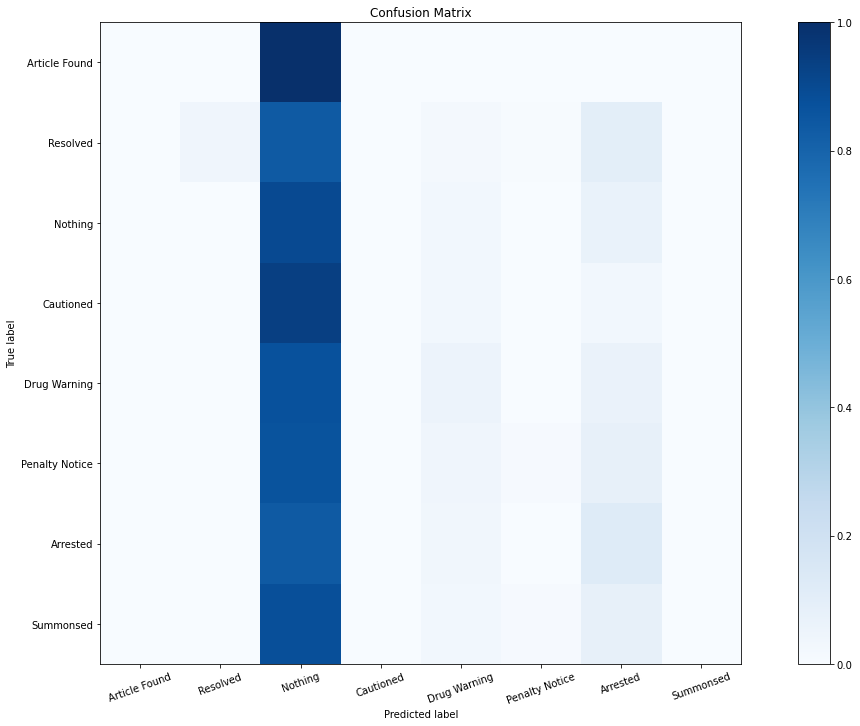

In [7]:
evaluate(model=knn, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

## Split target into "Police Action" (1) and "No Action" (0)

I will try to repeat the above process, but instead of the target being split into eight classes, I split it into two: either there was police action after the stop and search, or there wasn't.

In [8]:
#Replace all values in Outcome column, with 0 if "Nothing found - no further action", else 1.
# Reference for dictionary idea to replace values: https://stackoverflow.com/questions/17114904/python-pandas-replacing-strings-in-dataframe-with-numbers
outcome_splitter = {
    "Nothing found - no further action": 0, 
    "Article found - Detailed outcome unavailable": 1, 
    "Local resolution": 1,
    "Offender cautioned": 1,
    "Offender given drugs possession warning": 1,
    "Offender given penalty notice": 1,
    "Suspect arrested": 1,
    "Suspect summonsed to court": 1
    }
data_binary = data.applymap(lambda s: outcome_splitter.get(s) if s in outcome_splitter else s)
data_binary.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,Person search,2015-03-02 16:40:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
1,Person search,2015-03-02 16:40:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
2,Person search,2015-03-02 18:45:00+00:00,51.512286,-0.114491,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
4,Person and Vehicle search,2015-03-03 15:50:00+00:00,51.512286,-0.114491,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,1
5,Person search,2015-03-03 20:20:00+00:00,51.512286,-0.114491,Male,25-34,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,0


In [9]:
data_binary_encoded, encoders_binary = util.data_encoder(data_binary)

print(encoders_binary)
data_binary_encoded.head()

{'Type Encoder': LabelEncoder(), 'Date Encoder': LabelEncoder(), 'Gender Encoder': LabelEncoder(), 'Age range Encoder': LabelEncoder(), 'Officer-defined ethnicity Encoder': LabelEncoder(), 'Legislation Encoder': LabelEncoder(), 'Object of search Encoder': LabelEncoder(), 'Outcome Encoder': LabelEncoder()}


,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,1
1,1,0,51.512286,-0.114491,1,1,0,4,8,1
2,1,1,51.512286,-0.114491,1,1,4,4,8,1
4,0,2,51.512286,-0.114491,1,1,4,4,8,1
5,1,3,51.512286,-0.114491,1,1,0,3,3,0


In [10]:
# Split into features and target
target_binary = data_binary_encoded["Outcome"]
features_binary = data_binary_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(features_binary, target_binary, test_size=0.2, random_state=10)

Train (Binary) score: 0.7409221249622698
Test (Binary) score: 0.607014578491443

 Confusion matrix


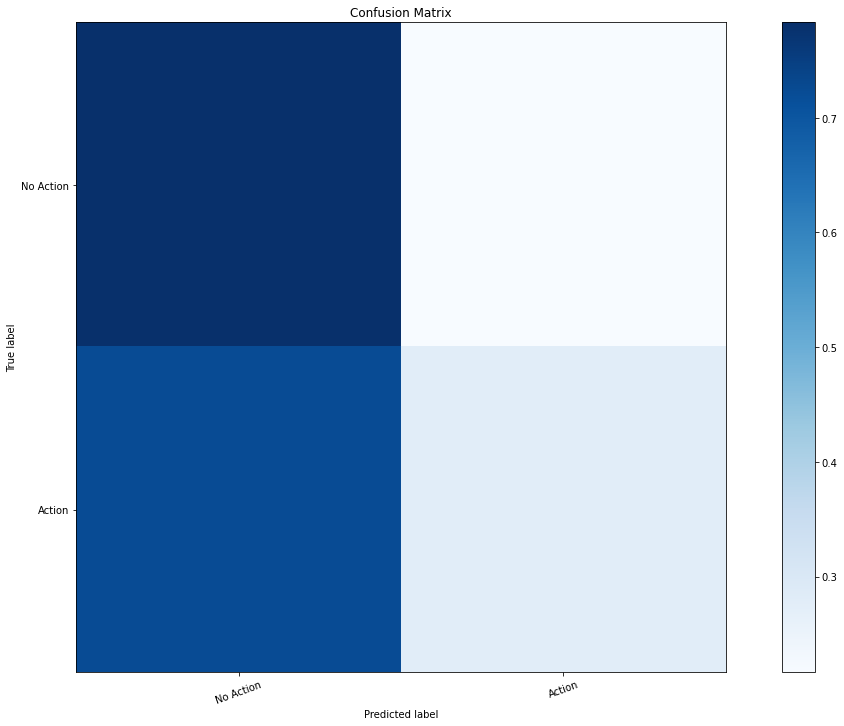

In [11]:
knn_binary = KNeighborsClassifier()
knn_binary.fit(X_train_binary, y_train_binary) 
print(f"Train (Binary) score: {knn_binary.score(X_train_binary, y_train_binary)}")
print(f"Test (Binary) score: {knn_binary.score(X_test_binary, y_test_binary)}")
print(f"\n Confusion matrix")

y_predictions_binary = knn_binary.predict(X_test_binary)
util.confusion_plot(y_test=y_test_binary, y_predictions=y_predictions_binary, target_classes=["No Action", "Action"])


Still, the model is heavily biased towards predicting no-action after a stop and search.

Let's compare the ratio of no-action to action in our y_train and y_test... perhaps our training data doesn't capture this ratio well

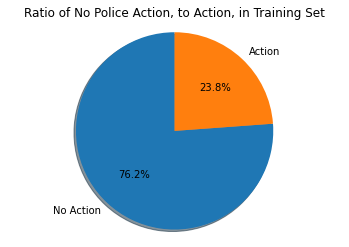

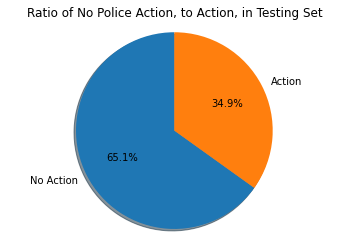

In [12]:
#Reference for Pie Chart: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
_, frequencies_predict = np.unique(y_predictions_binary, return_counts=True)
_, frequencies_test = np.unique(y_test_binary, return_counts=True)

labels = ["No Action", "Action"]

fig1, ax1 = plt.subplots()
ax1.pie(frequencies_predict, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of No Police Action, to Action, in Training Set")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(frequencies_test, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of No Police Action, to Action, in Testing Set")
plt.show()

As seen above, there is a signfiicant mismatch between the number of 0s and 1s when comparing the test set vs the training set. Perhaps K Cross Validation will be better for train/test splitting.

## Training Using K-Fold Cross Validation

In [13]:

#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_binary_k, X_test_binary_k, y_train_binary_k, y_test_binary_k = train_test_split(features_binary, target_binary, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [X_train_binary_k, y_train_binary_k]
k_fold_binary_data = pd.concat(frames, axis=1)

#K-cross validation on k_fold_binary_data 
knn_kfold = KNeighborsClassifier()
util.k_fold_train(model=knn_kfold, data=k_fold_binary_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Training Score: 0.7398883187443405
Testig Score: 0.7398883187443405


Fold #2, Training Size: 119268, Validation Size: 29817
Training Score: 0.7397457826072374
Testig Score: 0.7397457826072374


Fold #3, Training Size: 119268, Validation Size: 29817
Training Score: 0.7399721635308717
Testig Score: 0.7399721635308717


Fold #4, Training Size: 119268, Validation Size: 29817
Training Score: 0.7381359627058389
Testig Score: 0.7381359627058389


Fold #5, Training Size: 119268, Validation Size: 29817
Training Score: 0.7387061072542509
Testig Score: 0.7387061072542509




As you can see, performance is better when splitting using k-fold. Also significantly less difference between training and testing scores, implying less overfitting.

Let's plot a confusion matrix, using the testing data set above. Notice, this is data that has not been used to train the model using K cross valdiation.

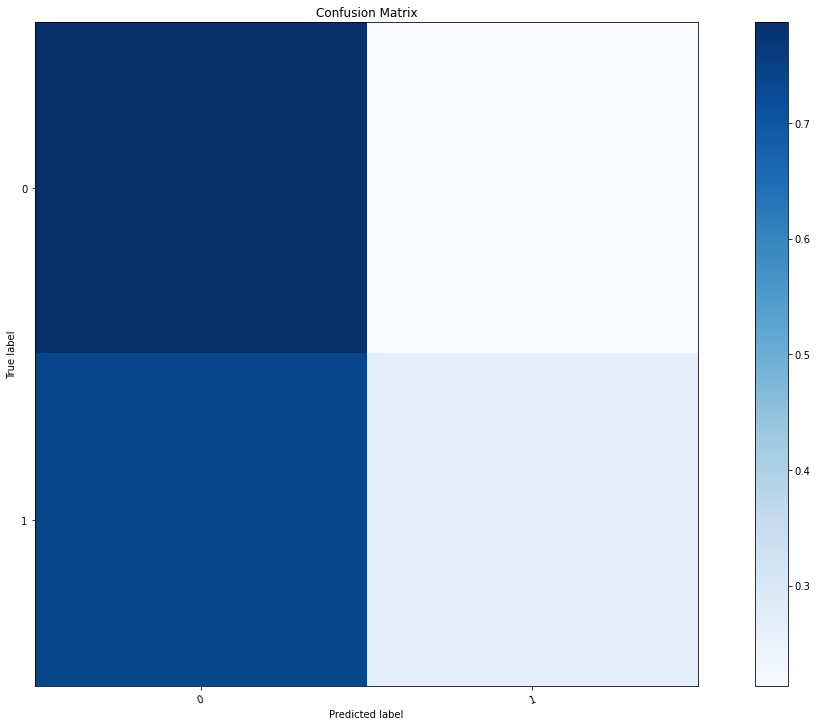

In [14]:
y_predict_binary_k = knn_kfold.predict(X_test_binary_k)
util.confusion_plot(y_test=y_test_binary_k, y_predictions=y_predict_binary_k, target_classes=[0, 1])

Less false negatives, although still signficant bias to predicting no police action after stop and search.

## K-fold with all target classes

We repeat the above process, but using all target categories for the sake of completion.

In [15]:
#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(features, target, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames_2 = [X_train_k, y_train_k]
k_fold_data = pd.concat(frames_2, axis=1)

#K-cross validation on k_fold_binary_data 
knn_kfold_all_classes = KNeighborsClassifier()
util.k_fold_train(model=knn_kfold_all_classes, data=k_fold_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Training Score: 0.6972364758359325
Testig Score: 0.6972364758359325


Fold #2, Training Size: 119268, Validation Size: 29817
Training Score: 0.6980078478720193
Testig Score: 0.6980078478720193


Fold #3, Training Size: 119268, Validation Size: 29817
Training Score: 0.6969681725190328
Testig Score: 0.6969681725190328


Fold #4, Training Size: 119268, Validation Size: 29817
Training Score: 0.6967417915953986
Testig Score: 0.6967417915953986


Fold #5, Training Size: 119268, Validation Size: 29817
Training Score: 0.6975886239393635
Testig Score: 0.6975886239393635




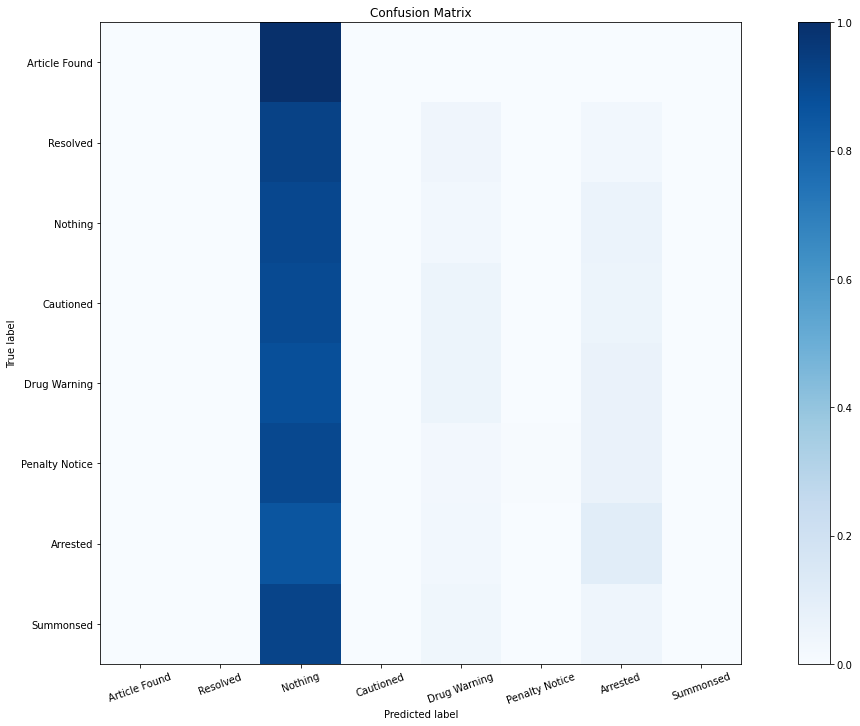

In [16]:
y_predict_k_a = knn_kfold_all_classes.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k_a)

The model pefroms better than without k-fold cross validation, however is once again, still clearly biased towards predicting no police action following from a search.

# Using SMOTE

We use SMOTE to even out the unbalanced dataset

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


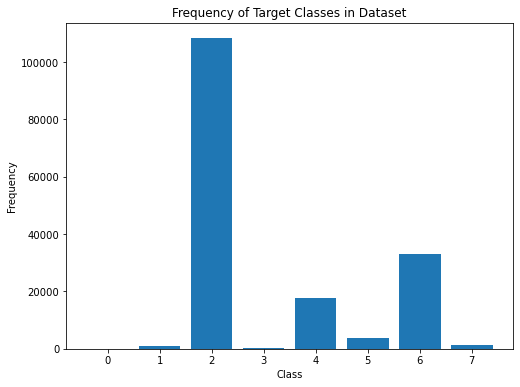

In [7]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"], figsize=(8,6))

Class 0: 0.03%     (34)
Class 1: 0.68%     (897)
Class 2: 65.33%     (86574)
Class 3: 0.1%     (135)
Class 4: 10.79%     (14296)
Class 5: 2.34%     (3102)
Class 6: 19.98%     (26474)
Class 7: 0.76%     (1008)
Total: 132520


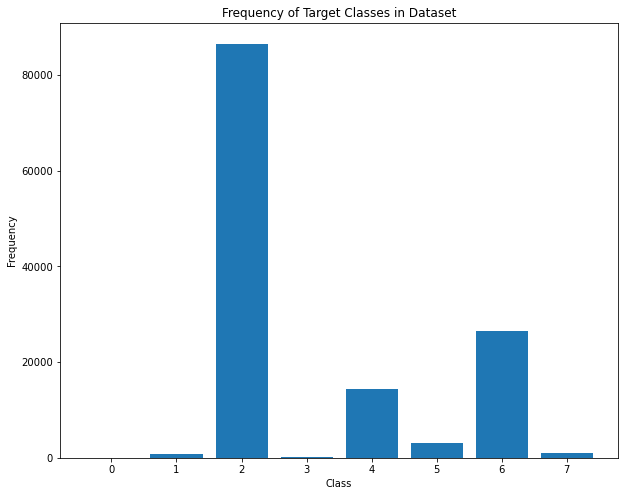

In [8]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

usm.display_frequencies(y_train)

Class 0: 12.5%     (86574)
Class 1: 12.5%     (86574)
Class 2: 12.5%     (86574)
Class 3: 12.5%     (86574)
Class 4: 12.5%     (86574)
Class 5: 12.5%     (86574)
Class 6: 12.5%     (86574)
Class 7: 12.5%     (86574)
Total: 692592


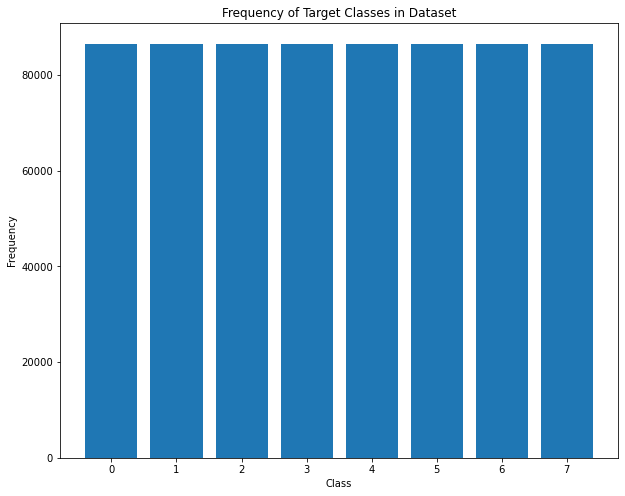

In [9]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
usm.display_frequencies(y_smote)

In [20]:
knn_smote = KNeighborsClassifier()
knn_smote.fit(X_smote, y_smote)

KNeighborsClassifier()

Accurancy Score (Train): 56%
Accuracy Score (Test): 24%

Precision Score (Train): 81%
Precision Score (Test): 56%

Recall Score (Train): 56%
Recall Score (Test): 24%

F1 Score (Train): 63%
F1 Score (Test): 32%

 Confusion Matrix


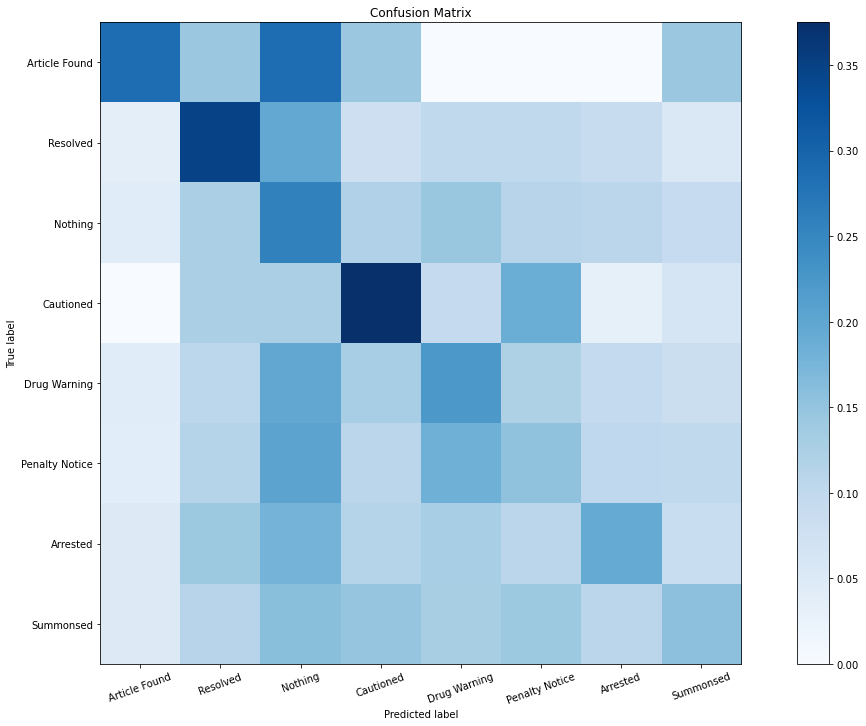

In [12]:
evaluate(model=knn_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average='weighted')

# Using Biased SMOTE (to majority class)
We over sample minority classes, but not to an extent that equalizes them to the majority class


Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


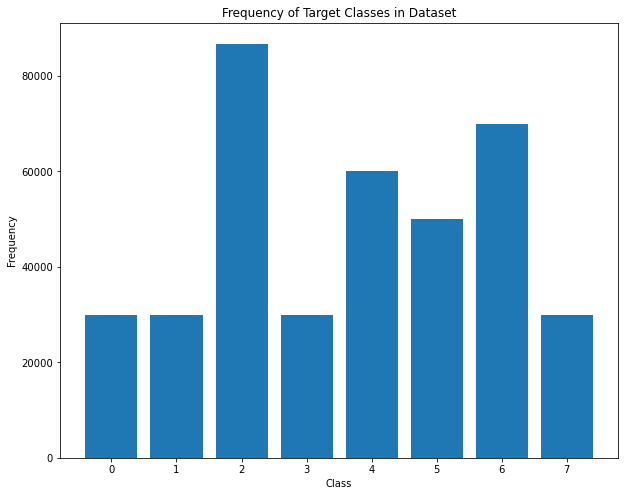

In [22]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote2, y_smote2 = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote2)

In [23]:
knn_smote_biased = KNeighborsClassifier()
knn_smote_biased.fit(X_smote2, y_smote2)

KNeighborsClassifier()

Accurancy Score (Train): 64%
Accuracy Score (Test): 34%

Precision Score (Train): 77%
Precision Score (Test): 54%

Recall Score (Train): 64%
Recall Score (Test): 34%

F1 Score (Train): 68%
F1 Score (Test): 41%

 Confusion Matrix


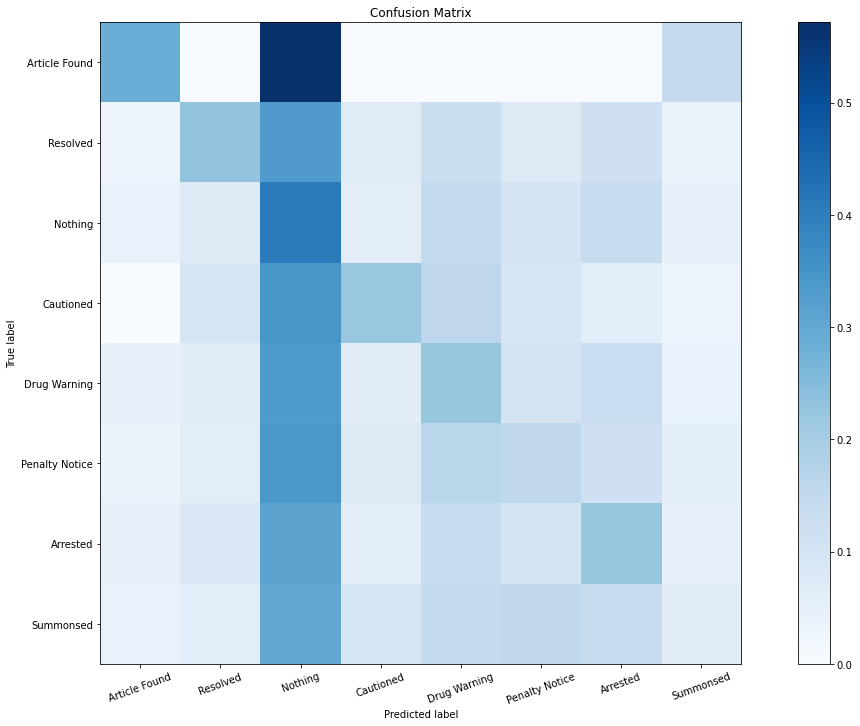

In [24]:
evaluate(model=knn_smote_biased, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

# Using Biased SMOTE (to minority class)


Class 0: 13.95%     (160000)
Class 1: 13.95%     (160000)
Class 2: 7.57%     (86784)
Class 3: 13.95%     (160000)
Class 4: 12.21%     (140000)
Class 5: 13.08%     (150000)
Class 6: 11.34%     (130000)
Class 7: 13.95%     (160000)
Total: 1146784


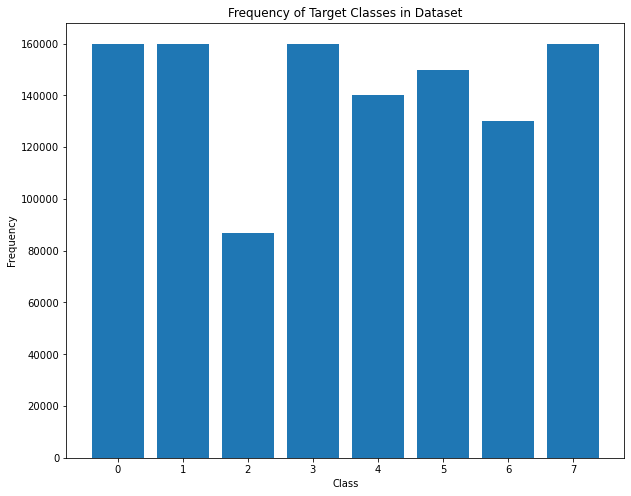

In [25]:
sampling_strategy = {0:160000, 1:160000, 2:86784, 3:160000, 4:140000, 5:150000, 6:130000, 7:160000}
X_smote3, y_smote3 = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote3)

In [26]:
knn_smote_biased_min = KNeighborsClassifier()
knn_smote_biased_min.fit(X_smote3, y_smote3)

KNeighborsClassifier()

Accurancy Score (Train): 52%
Accuracy Score (Test): 19%

Precision Score (Train): 83%
Precision Score (Test): 56%

Recall Score (Train): 52%
Recall Score (Test): 19%

F1 Score (Train): 57%
F1 Score (Test): 26%

 Confusion Matrix


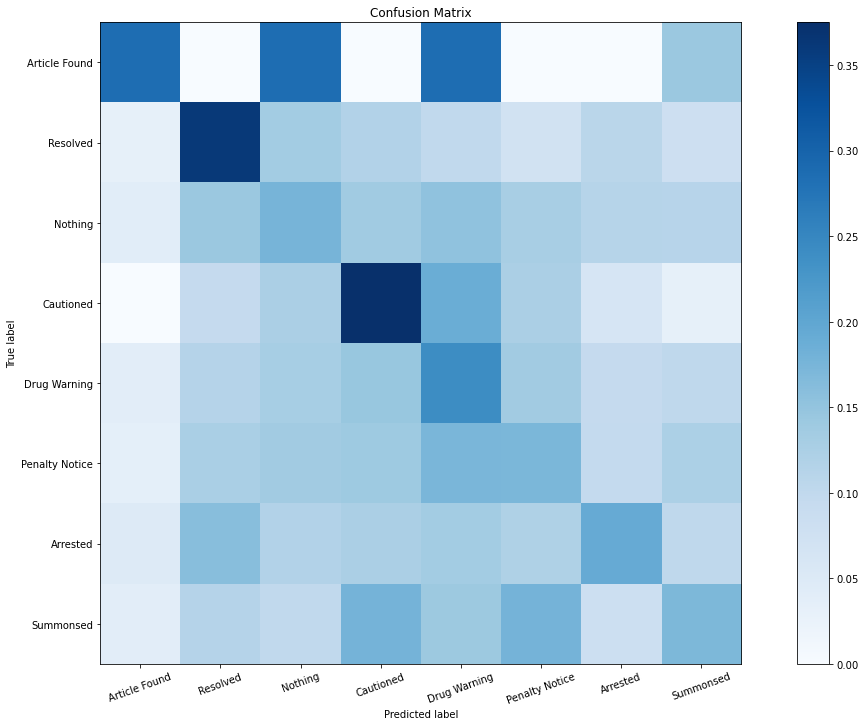

In [27]:
evaluate(model=knn_smote_biased_min, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

## Undersampling



Class 0: 0.04%     (34)
Class 1: 1.01%     (897)
Class 2: 48.51%     (43287)
Class 3: 0.15%     (135)
Class 4: 16.02%     (14296)
Class 5: 3.48%     (3102)
Class 6: 29.67%     (26474)
Class 7: 1.13%     (1008)
Total: 89233


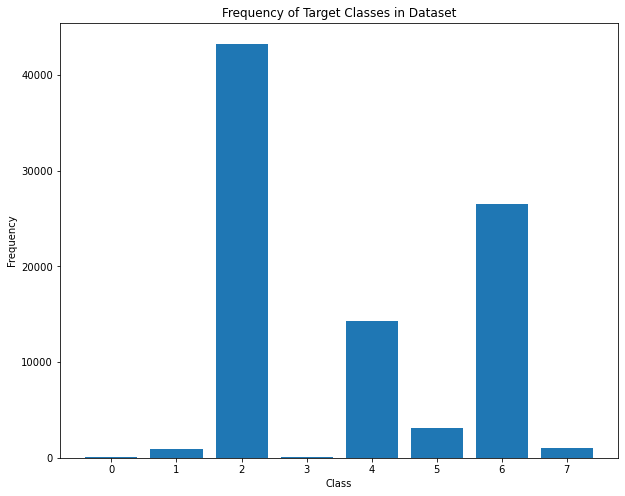

In [28]:
X_under, y_under= usm.under_sample(X_train, y_train, majority_multiplier=0.5)
usm.display_frequencies(y_under)

In [29]:
knn_smote_under_sample = KNeighborsClassifier()
knn_smote_under_sample.fit(X_under, y_under)

KNeighborsClassifier()

Accurancy Score (Train): 64%
Accuracy Score (Test): 54%

Precision Score (Train): 62%
Precision Score (Test): 51%

Recall Score (Train): 64%
Recall Score (Test): 54%

F1 Score (Train): 63%
F1 Score (Test): 52%

 Confusion Matrix


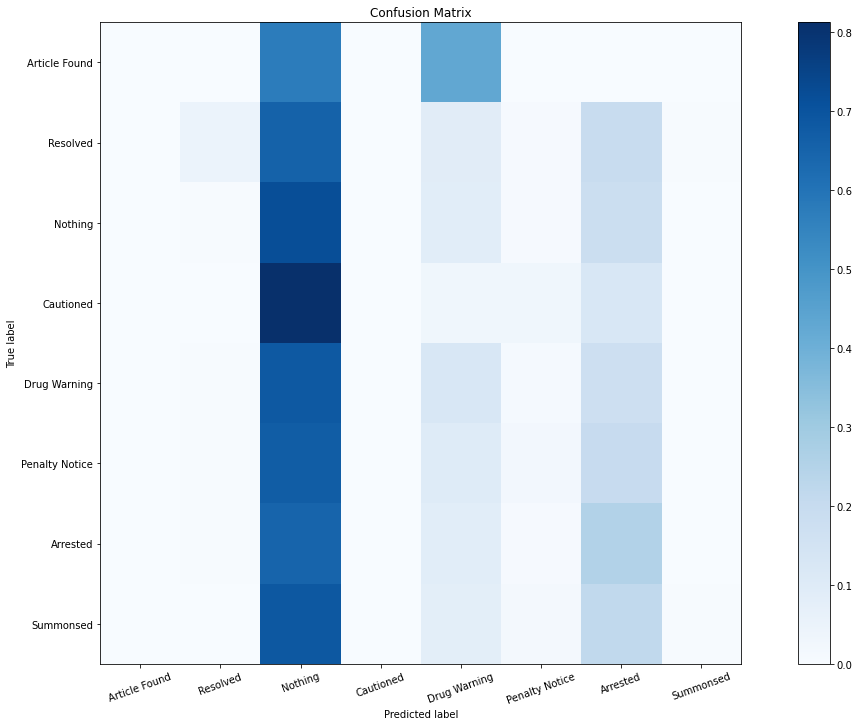

In [30]:
evaluate(model=knn_smote_under_sample, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

## Undersample + SMOTE

Class 0: 12.5%     (77916)
Class 1: 12.5%     (77916)
Class 2: 12.5%     (77916)
Class 3: 12.5%     (77916)
Class 4: 12.5%     (77916)
Class 5: 12.5%     (77916)
Class 6: 12.5%     (77916)
Class 7: 12.5%     (77916)
Total: 623328


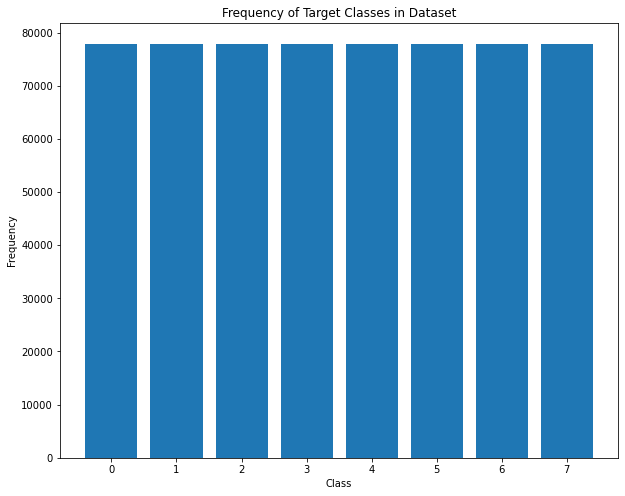

In [37]:
X_under2, y_under2= usm.under_sample(X_train, y_train, majority_multiplier=0.9)
X_smote4, y_smote4 = usm.smote_data(X_under2, y_under2)
usm.display_frequencies(y_smote4)

In [38]:
knn_smote_under_and_smote = KNeighborsClassifier()
knn_smote_under_and_smote.fit(X_smote4, y_smote4)

KNeighborsClassifier()

Accurancy Score (Train): 53%
Accuracy Score (Test): 23%

Precision Score (Train): 80%
Precision Score (Test): 56%

Recall Score (Train): 53%
Recall Score (Test): 23%

F1 Score (Train): 60%
F1 Score (Test): 31%

 Confusion Matrix


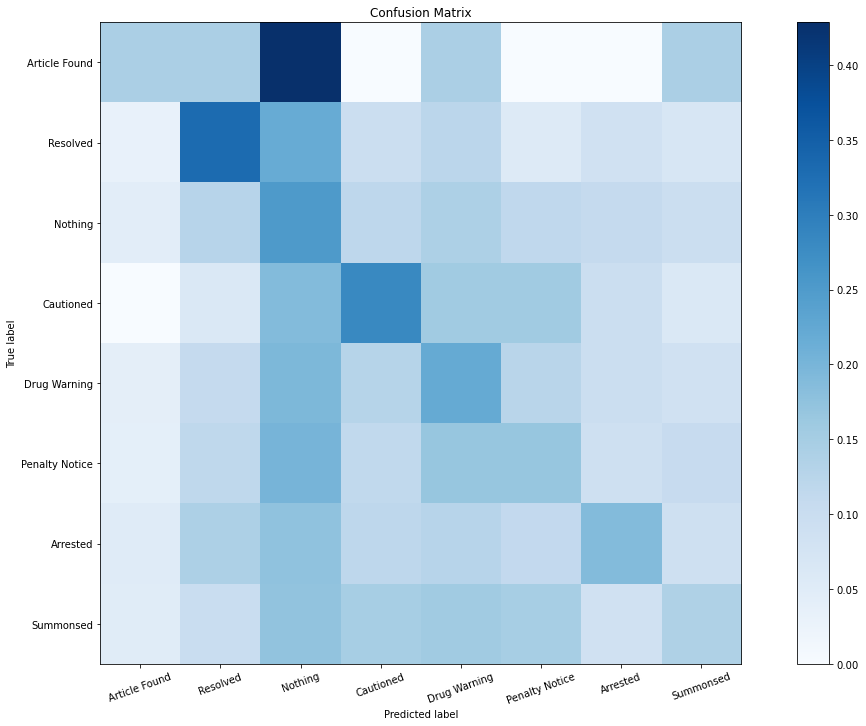

In [39]:
evaluate(model=knn_smote_under_and_smote, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

Best precision test scores using SMOTE, with frequencies for all classes regularized

## Scaling Data

In [13]:
# X_smote, y_smote 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_smote)
X_test_scaled = scaler.fit_transform(X_test)

print(X_train_scaled.shape)
print(X_smote.shape)

(692592, 9)
(692592, 9)


In [14]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_smote)

KNeighborsClassifier()

## Using Grid Search to Tune Hyperparameters

In [16]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    "n_neighbors":[5, 11, 19],
    "weights":["uniform", "distance"],
    "metric":["euclidean", "manhattan"]
}